<a href="https://colab.research.google.com/github/me-t1me/DIP_assignment_2/blob/master/DIP_2_Q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Apr 23 18:59:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q keras

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
""" Global parameters """
H = 512
W = 512

# Loading and making train test dataset


In [5]:
import os
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision


## helper functions for data

In [6]:
def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)

In [7]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "CXR_png", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    img_list = []
    mask_list = []
    

    for mask in masks:
      id = mask.split("_mask")[1].split("masks/")[1]
      for image in images:
        img_id = image.split("CXR_png/")[1].split(".png")[0]
        if id == img_id:
          img_list.append(image)
          mask_list.append(mask)
          break
          
      
    images = img_list
    masks = mask_list
    
    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [8]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.float32)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W])
    y.set_shape([H, W])
    return x, y

def tf_dataset(X, Y):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.shuffle(buffer_size=200)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(8)
    dataset = dataset.prefetch(4)
    return dataset

## making dataset

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

dataset_path = "/content/drive/MyDrive/X_ray_image_and_mask_for_U_net_training"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")

train_dataset = tf_dataset(train_x, train_y)
valid_dataset = tf_dataset(valid_x, valid_y)

Train: 454 - 454
Valid: 56 - 56
Test: 56 - 56


# Creating model

In [10]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model


In [11]:
def conv_block(input, neurons):
  conv = Conv2D(neurons, (3, 3), activation="relu", padding="same")(input)
  conv = Conv2D(neurons, (3, 3), activation="relu", padding="same")(conv)
  return conv

In [12]:
def block1(input, neurons, drop):
  conv = conv_block(input, neurons)
  pool = MaxPool2D((2, 2))(conv)
  pool = Dropout(drop)(pool)
  return conv, pool

In [13]:
def block2(conv, input, neurons, drop):
  deconv = Conv2DTranspose(neurons,(3,3), strides=(2,2), padding="same")(input)
  unconv = Concatenate()([deconv, conv])
  unconv = Dropout(drop)(unconv)
  unconv = conv_block(unconv, neurons)
  return unconv

In [33]:
def build_model(input_layer, neurons):
  conv1, pool1 = block1(input_layer, neurons, 0.25)
  conv2, pool2 = block1(pool1, neurons*2, 0.5)
  conv3, pool3 = block1(pool2, neurons*4, 0.5)
  conv4, pool4 = block1(pool3, neurons*8, 0.5)

  convm = conv_block(pool4, neurons*16)

  uconv4 = block2(conv4, convm,neurons*8, 0.5 )
  uconv3 = block2(conv3, uconv4,neurons*4, 0.5 )
  uconv2 = block2(conv2, uconv3,neurons*2, 0.5 )
  uconv1 = block2(conv1, uconv2,neurons*1, 0.5 )

  output = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

  return output

In [34]:
input_layer = Input((W, H, 1))
output = build_model(input_layer, 16)
model = Model(input_layer, output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 512, 512, 16  2320        ['conv2d_19[0][0]']              
                                )                                                           

# training

In [35]:
batch_size = 2
num_epochs = 10

In [36]:
np.random.seed(42)
tf.random.set_seed(42)
create_dir("files")
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "data.csv")


In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [38]:
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path)
    ]

In [39]:
 model_history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Epoch 1/10
57/57 [==============================] - ETA: 0s - loss: 0.5620 - accuracy: 0.7423
Epoch 1: val_loss improved from inf to 0.47801, saving model to files/model.h5
57/57 [==============================] - 103s 2s/step - loss: 0.5620 - accuracy: 0.7423 - val_loss: 0.4780 - val_accuracy: 0.7530 - lr: 0.0010
Epoch 2/10
57/57 [==============================] - ETA: 0s - loss: 0.3497 - accuracy: 0.8047
Epoch 2: val_loss did not improve from 0.47801
57/57 [==============================] - 86s 2s/step - loss: 0.3497 - accuracy: 0.8047 - val_loss: 0.7868 - val_accuracy: 0.8475 - lr: 0.0010
Epoch 3/10
57/57 [==============================] - ETA: 0s - loss: 0.1783 - accuracy: 0.9333
Epoch 3: val_loss improved from 0.47801 to 0.31259, saving model to files/model.h5
57/57 [==============================] - 87s 2s/step - loss: 0.1783 - accuracy: 0.9333 - val_loss: 0.3126 - val_accuracy: 0.8828 - lr: 0.0010
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.1454 - accur

# Testing

In [40]:
import matplotlib.pyplot as plt

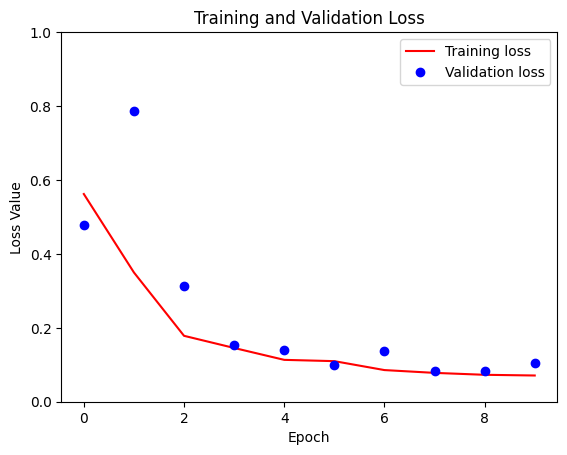

In [41]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [42]:
model.layers[0].input

<KerasTensor: shape=(None, 512, 512, 1) dtype=float32 (created by layer 'input_2')>

1/1 [==============================] - 1s 974ms/step
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
image:


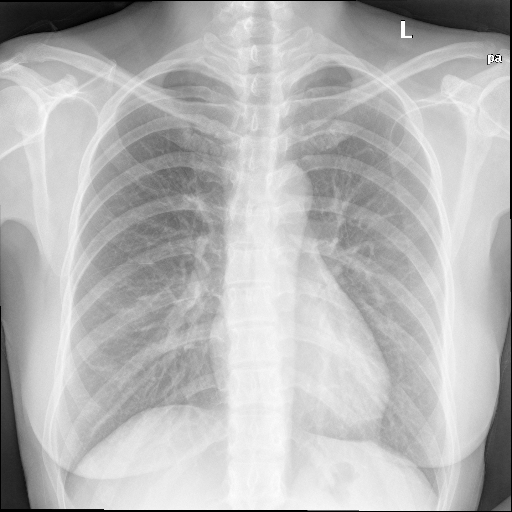

real mask:


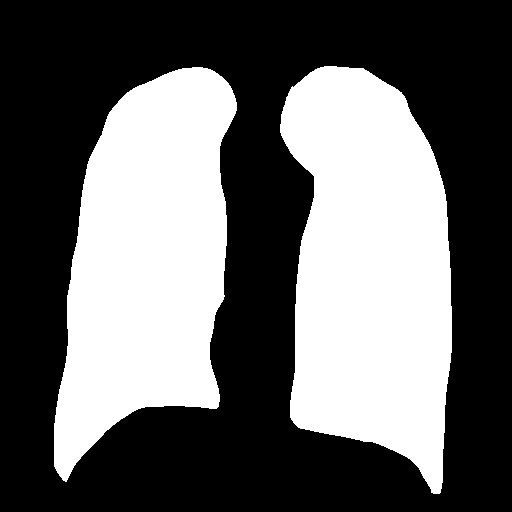

prediction:


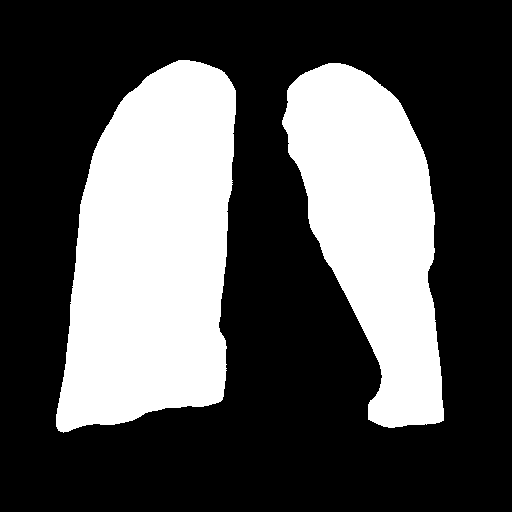

-------------------------
1/1 [==============================] - 0s 27ms/step
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
image:


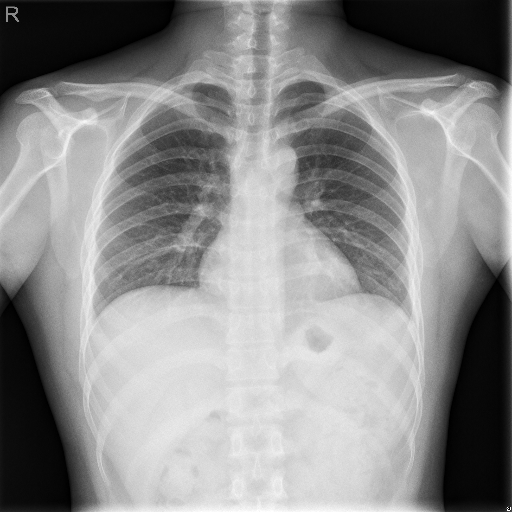

real mask:


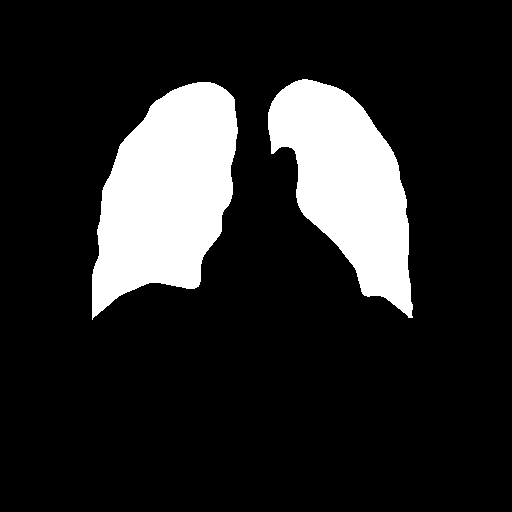

prediction:


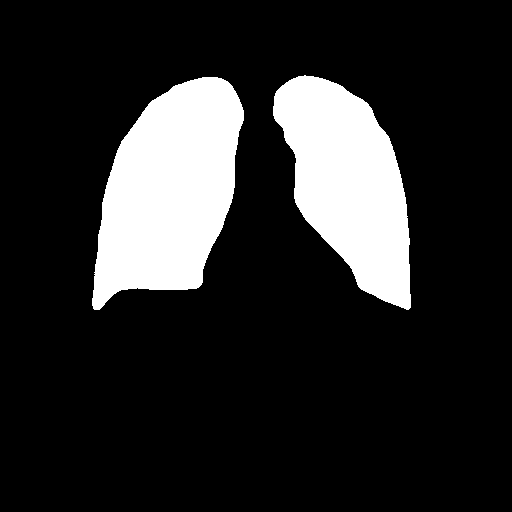

-------------------------
1/1 [==============================] - 0s 26ms/step
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
image:


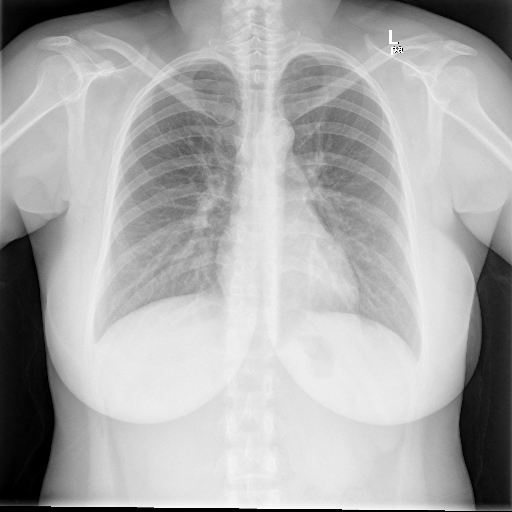

real mask:


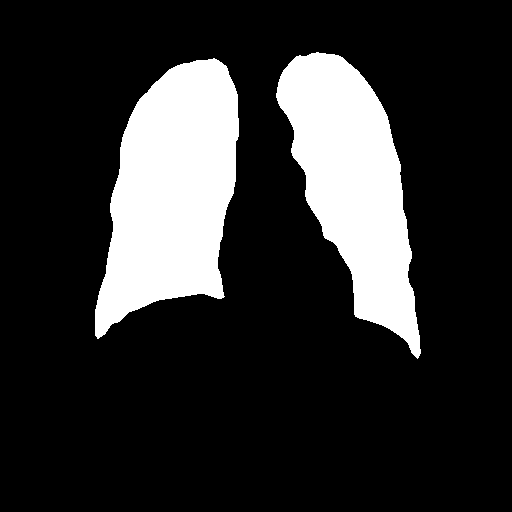

prediction:


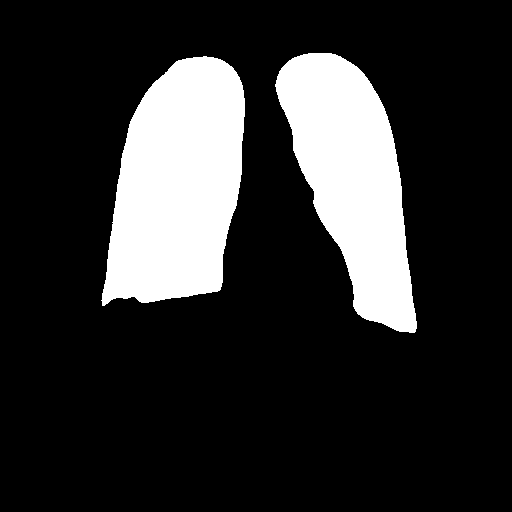

-------------------------


In [43]:
from tqdm import tqdm
from random import randrange
from google.colab.patches import cv2_imshow
     
for _ in range(3):
  i = randrange(0, len(test_x))

  image = read_image(test_x[i])
  # image = np.expand_dims(image, axis=-1) 
  image_tmp = image.astype(np.float32)
  image_tmp = image_tmp.reshape(-1, W, H, 1)

  real_mask = read_mask(test_y[i])
  

  pred_mask = model.predict(image_tmp) > 0.5
  pred_mask = pred_mask.reshape(W, H)
  pred_mask = pred_mask.astype(np.int32)
  print(pred_mask)

  print("image:")
  cv2_imshow(image*255)
  print("real mask:")
  cv2_imshow(real_mask*255)
  print("prediction:")
  cv2_imshow(pred_mask*255)
  print("-------------------------")

# for x, y in tqdm(zip(test_x, test_y), total = len(test_x)):
#   image_name = x.split("/")[-1]
#   image = read_image(x)
#   real_mask = read_mask(y)

#   pred_mask = model.predict(x) > 0.5
#   pred_mask = 